In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import re
from nltk.stem import PorterStemmer

In [11]:
#Load in the data
train_file_path = '/kaggle/input/nlp-getting-started/train.csv'
test_file_path = '/kaggle/input/nlp-getting-started/test.csv'

# Load datasets
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Display basic information
print("Train DataFrame Info:")
print(train_df.info())
print("\nTrain DataFrame Head:")
print(train_df.head())

print("\nTest DataFrame Info:")
print(test_df.info())
print("\nTest DataFrame Head:")
print(test_df.head())

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Train DataFrame Head:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4  

In [12]:
#Take care of missing values
print("Missing Values in Train DataFrame:")
print(train_df.isnull().sum())

print("\nMissing Values in Test DataFrame:")
print(test_df.isnull().sum())

Missing Values in Train DataFrame:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test DataFrame:
id             0
keyword       26
location    1105
text           0
dtype: int64


Shape of Train Data: (7613, 7)

Missing Values:
 id                0
keyword          61
location       2533
text              0
target            0
text_length       0
word_count        0
dtype: int64

Target Distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


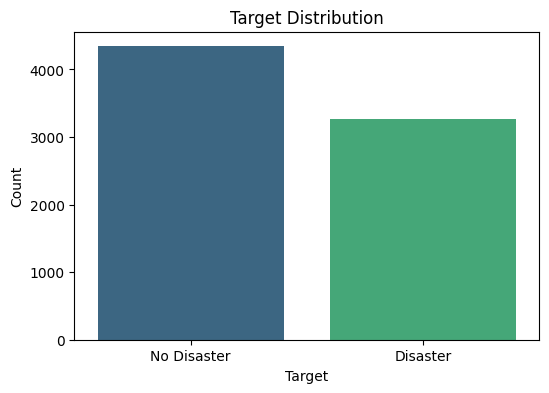

In [15]:
print("Shape of Train Data:", train_df.shape)
print("\nMissing Values:\n", train_df.isnull().sum())
print("\nTarget Distribution:")
print(train_df['target'].value_counts(normalize=True))

#Target Distribution vs Count (Disaster vs No Disaster)
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='target', palette='viridis')
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Disaster', 'Disaster'])
plt.show()


Text Length Statistics:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


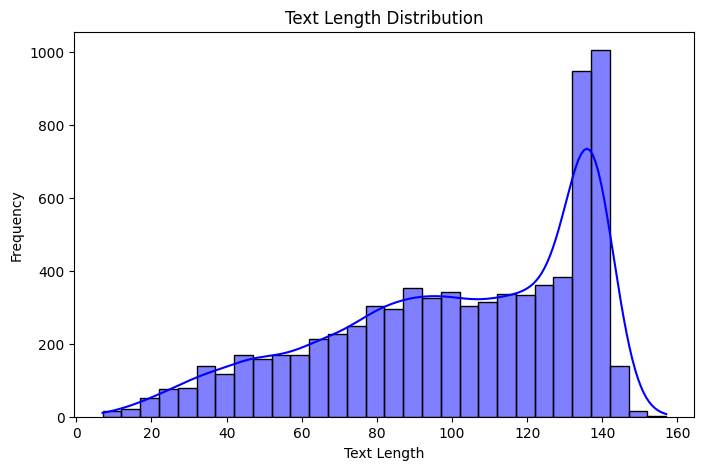

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


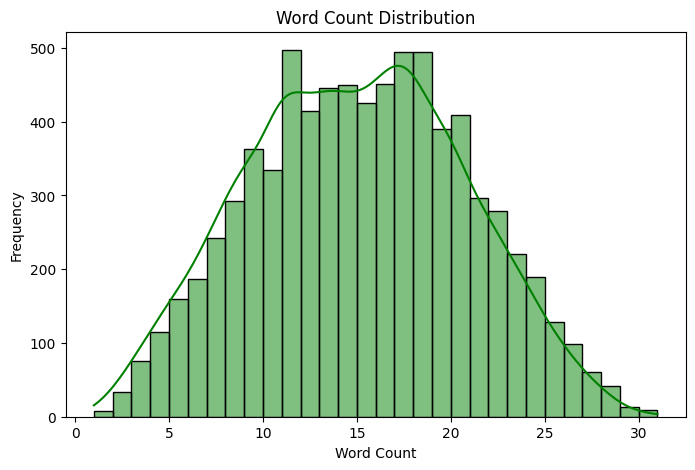

In [17]:
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

print("\nText Length Statistics:")
print(train_df['text_length'].describe())

#look at text length and word count over frequency
plt.figure(figsize=(8, 5))
sns.histplot(train_df['text_length'], bins=30, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(train_df['word_count'], bins=30, kde=True, color='green')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

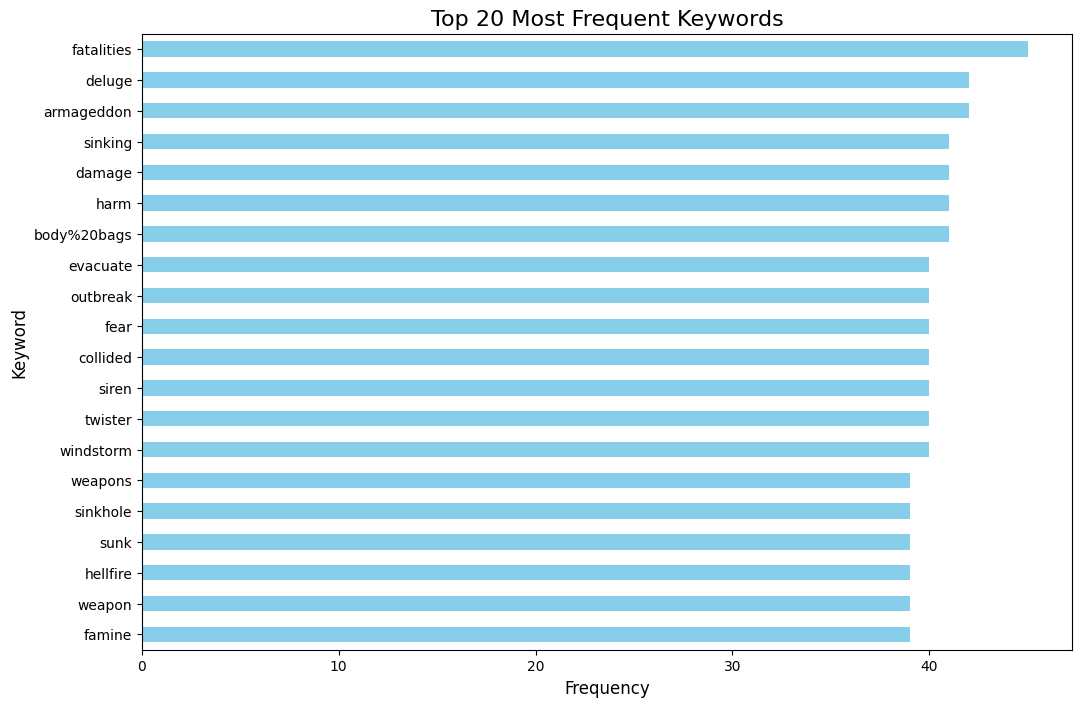

In [18]:

keyword_counts = train_df['keyword'].value_counts().head(20)

#Look at the most frequent words
plt.figure(figsize=(12, 8))
keyword_counts.sort_values().plot(kind='barh', color='skyblue')  # Sắp xếp giá trị tăng dần
plt.title('Top 20 Most Frequent Keywords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.show()

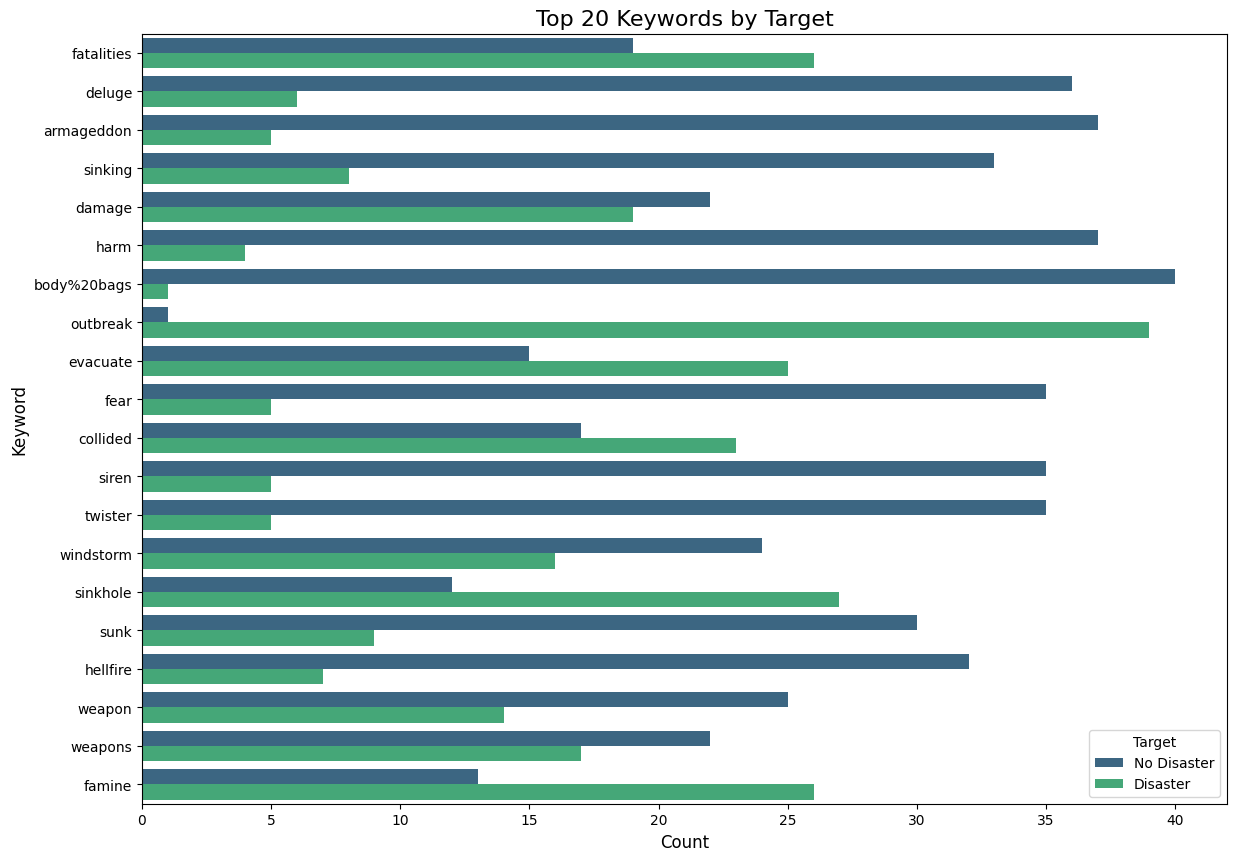

In [19]:
top_keywords = train_df['keyword'].value_counts().head(20).index

#filter to top keywords
filtered_df = train_df[train_df['keyword'].isin(top_keywords)]

# plot keywords in disaster vs no disaster
plt.figure(figsize=(14, 10))
sns.countplot(
    data=filtered_df,
    y='keyword',
    hue='target',
    order=top_keywords,
    palette='viridis'
)
plt.title('Top 20 Keywords by Target', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.legend(title='Target', labels=['No Disaster', 'Disaster'], loc='lower right')
plt.show()


Top 10 Locations:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


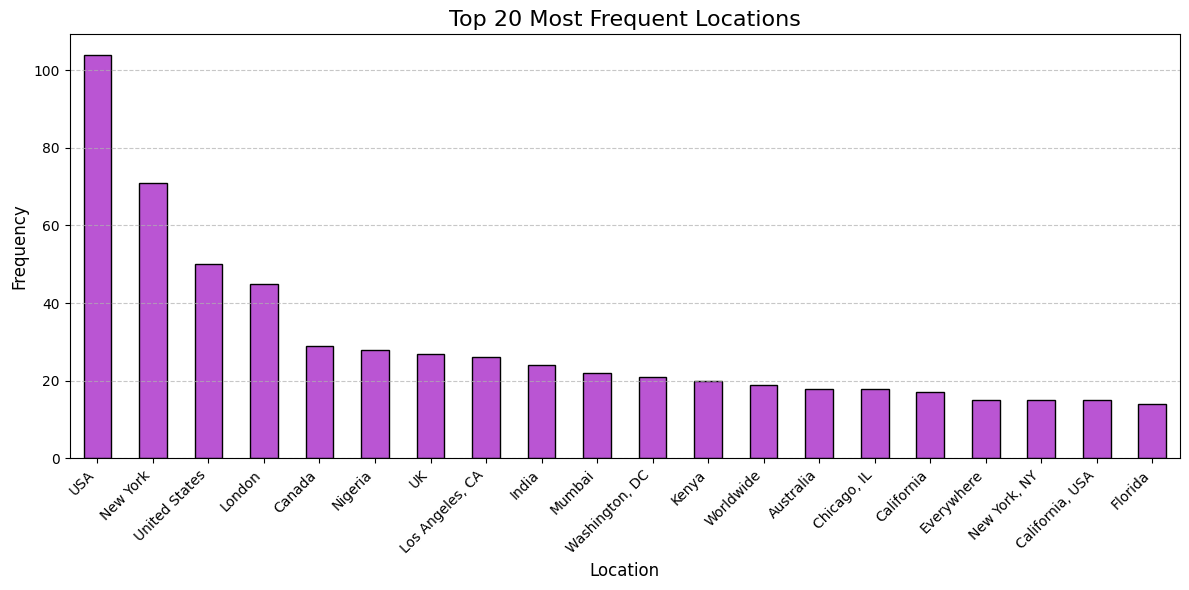

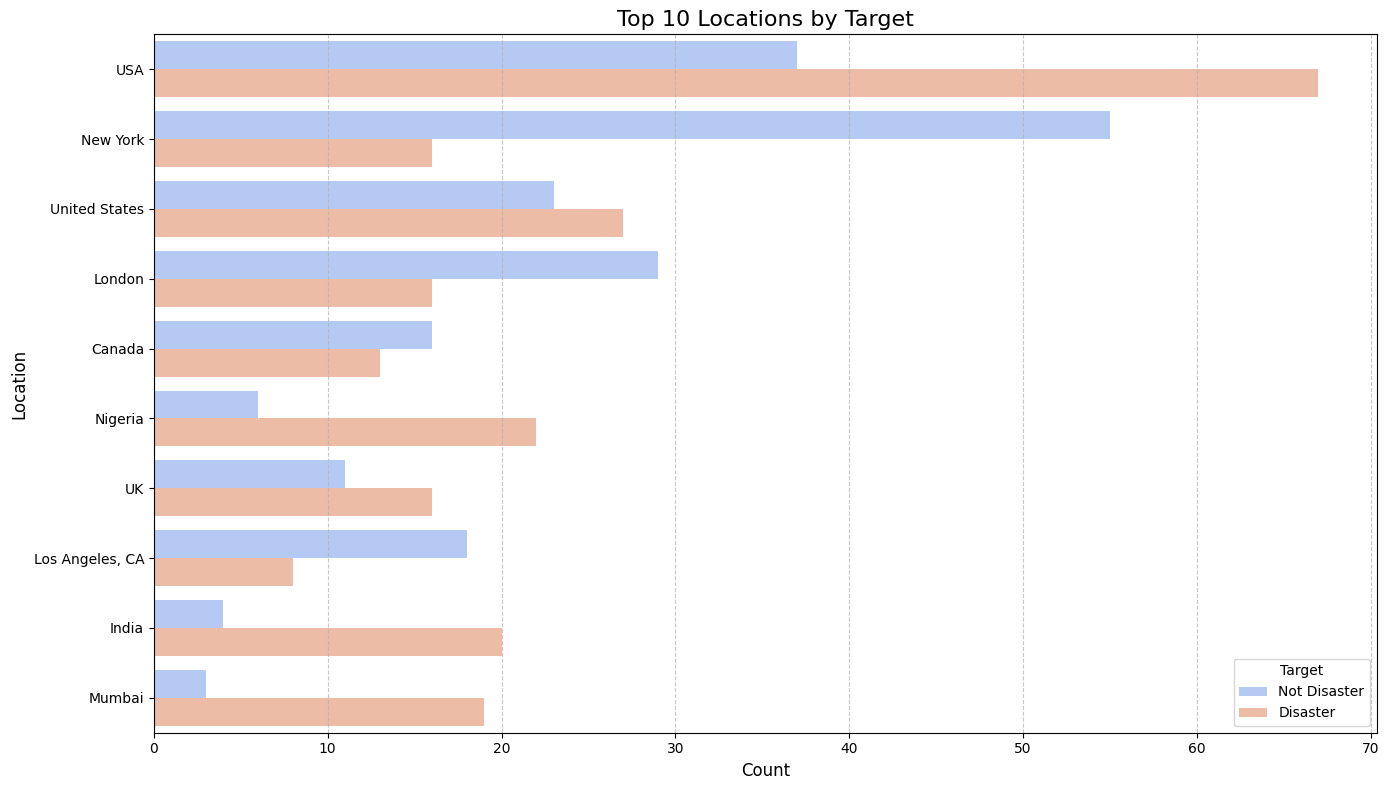

In [21]:
print("\nTop 10 Locations:")
top_10_locations = train_df['location'].value_counts().head(10)
print(top_10_locations)

#Look at top frequent locations
plt.figure(figsize=(12, 6))
top_20_locations = train_df['location'].value_counts().head(20)
top_20_locations.plot(kind='bar', color='mediumorchid', edgecolor='black')
plt.title('Top 20 Most Frequent Locations', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# top 10 locations by target
plt.figure(figsize=(14, 8))
sns.countplot(
    data=train_df,
    y='location',
    order=train_df['location'].value_counts().head(10).index,
    hue='target',
    palette='coolwarm'
)
plt.title('Top 10 Locations by Target', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.legend(title='Target', labels=['Not Disaster', 'Disaster'], loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

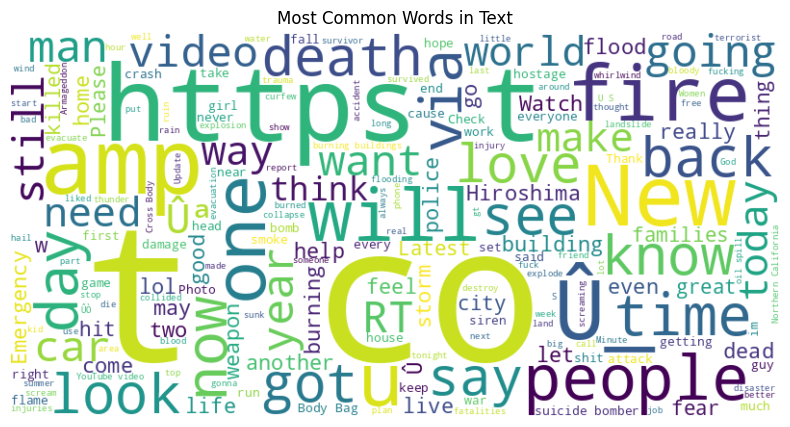

In [23]:
from wordcloud import WordCloud

text_data = ' '.join(train_df['text'])

#Make a word cloud of most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Text')
plt.show()

In [24]:
#Preprocessing
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#\w+|\d+|[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

In [25]:
#Model
def extract_features(df):
    df['text_length'] = df['text'].apply(len) 
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['hashtag_count'] = df['text'].apply(lambda x: x.count('#'))
    df['mention_count'] = df['text'].apply(lambda x: x.count('@')) 
    df['url_count'] = df['text'].apply(lambda x: len(re.findall(r"http\S+|www\S+", x)))  
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

#Vectorization for TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))

In [26]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

import scipy.sparse as sp
X_train = sp.hstack([X_train_tfidf, 
                     train_df[['text_length', 'word_count', 'hashtag_count', 'mention_count', 'url_count']].values])
X_test = sp.hstack([X_test_tfidf, 
                    test_df[['text_length', 'word_count', 'hashtag_count', 'mention_count', 'url_count']].values])

y_train = train_df['target']

# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)

# Training accuracy
xgb_train_acc = accuracy_score(y_train, y_pred_train_xgb)
print("XGBoost - Training Accuracy:", xgb_train_acc)

XGBoost - Training Accuracy: 0.8182057007749901


In [27]:
submission = pd.DataFrame({'id': test_df['id'], 'target': y_pred_test_xgb})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
